In [1]:
import pandas as pd
import numpy as np
import plotly
import chart_studio.plotly as py
import chart_studio
import matplotlib.pyplot as plt

chart_studio.tools.set_credentials_file(username='oystein.nerva', api_key='0ODcZ6UisJ8n0AjEQt9N')

In [143]:
url = "https://github.com/NRVA/COVID19_Norge/raw/master/COVID19_fhi_data_fylke.csv"
data = pd.read_csv(url, sep=';')
data

,Fylke,02-Mar-20,03-Mar-20,04-Mar-20,05-Mar-20,06-Mar-20,07-Mar-20,08-Mar-20,09-Mar-20,10-Mar-20,...,15-Mar-20,16-Mar-20,17-Mar-20,18-Mar-20,19-Mar-20,20-Mar-20,21-Mar-20,22-Mar-20,23-Mar-20,24-Mar-20
0,Agder,2,3,3,7,7,9,9,17,19,...,55,67,67,67,75,79,82,91,91,92
1,Innlandet,0,0,3,4,12,12,12,14,16,...,72,81,88,97,105,115,125,148,151,163
2,Møre og Romsdal,0,0,1,2,2,2,2,4,5,...,20,20,20,20,25,29,32,38,44,46
3,Nordland,0,0,0,0,1,2,3,3,3,...,8,11,11,12,13,17,17,18,18,18
4,Oslo,7,7,14,18,23,29,35,35,51,...,281,292,329,348,392,419,448,523,636,657
5,Rogaland,0,0,3,6,11,14,19,25,33,...,127,131,150,161,176,180,199,219,237,251
6,Troms og Finnmark,1,2,2,2,6,6,6,6,6,...,20,21,24,28,28,32,37,49,55,59
7,Trøndelag,0,0,1,7,15,18,19,22,22,...,50,52,61,70,75,97,122,131,144,158
8,Vestfold og Telemark,0,0,0,2,2,2,3,5,5,...,48,53,59,63,65,72,81,85,87,95
9,Vestland,9,12,17,22,24,24,24,28,31,...,118,127,141,147,153,173,200,214,234,279


In [6]:
url = "https://github.com/NRVA/COVID19_Norge/raw/master/Fylkestilhorighet_2020.csv"
fylker = pd.read_csv(url, sep=';')
fylker

,Fylke,RHF,Befolkning
0,Agder,Helse Sør-Øst,307231
1,Innlandet,Helse Sør-Øst,371385
2,Møre og Romsdal,Helse Midt-Norge,265238
3,Nordland,Helse Nord,241235
4,Oslo,Helse Sør-Øst,693494
5,Rogaland,Helse Vest,479892
6,Troms og Finnmark,Helse Nord,243311
7,Trøndelag,Helse Midt-Norge,468702
8,Vestfold og Telemark,Helse Sør-Øst,419396
9,Vestland,Helse Vest,636531


In [144]:
df = data.melt(id_vars=['Fylke']).copy()
df['variable'] = pd.to_datetime(df['variable'], errors='coerce')
df = df.groupby(["Fylke", pd.Grouper(key="variable", freq="d")]).max().reset_index()
df = df.pivot(index="variable", columns="Fylke", values="value")

restart = df.copy()

df.head()

Fylke,Agder,Innlandet,Møre og Romsdal,Nordland,Oslo,Rogaland,Troms og Finnmark,Trøndelag,Vestfold og Telemark,Vestland,Viken
variable,,,,,,,,,,,
2020-03-02,2,0,0,0,7,0,1,0,0,9,5
2020-03-03,3,0,0,0,7,0,2,0,0,12,8
2020-03-04,3,3,1,0,14,3,2,1,0,17,19
2020-03-05,7,4,2,0,18,6,2,7,2,22,23
2020-03-06,7,12,2,1,23,11,6,15,2,24,26


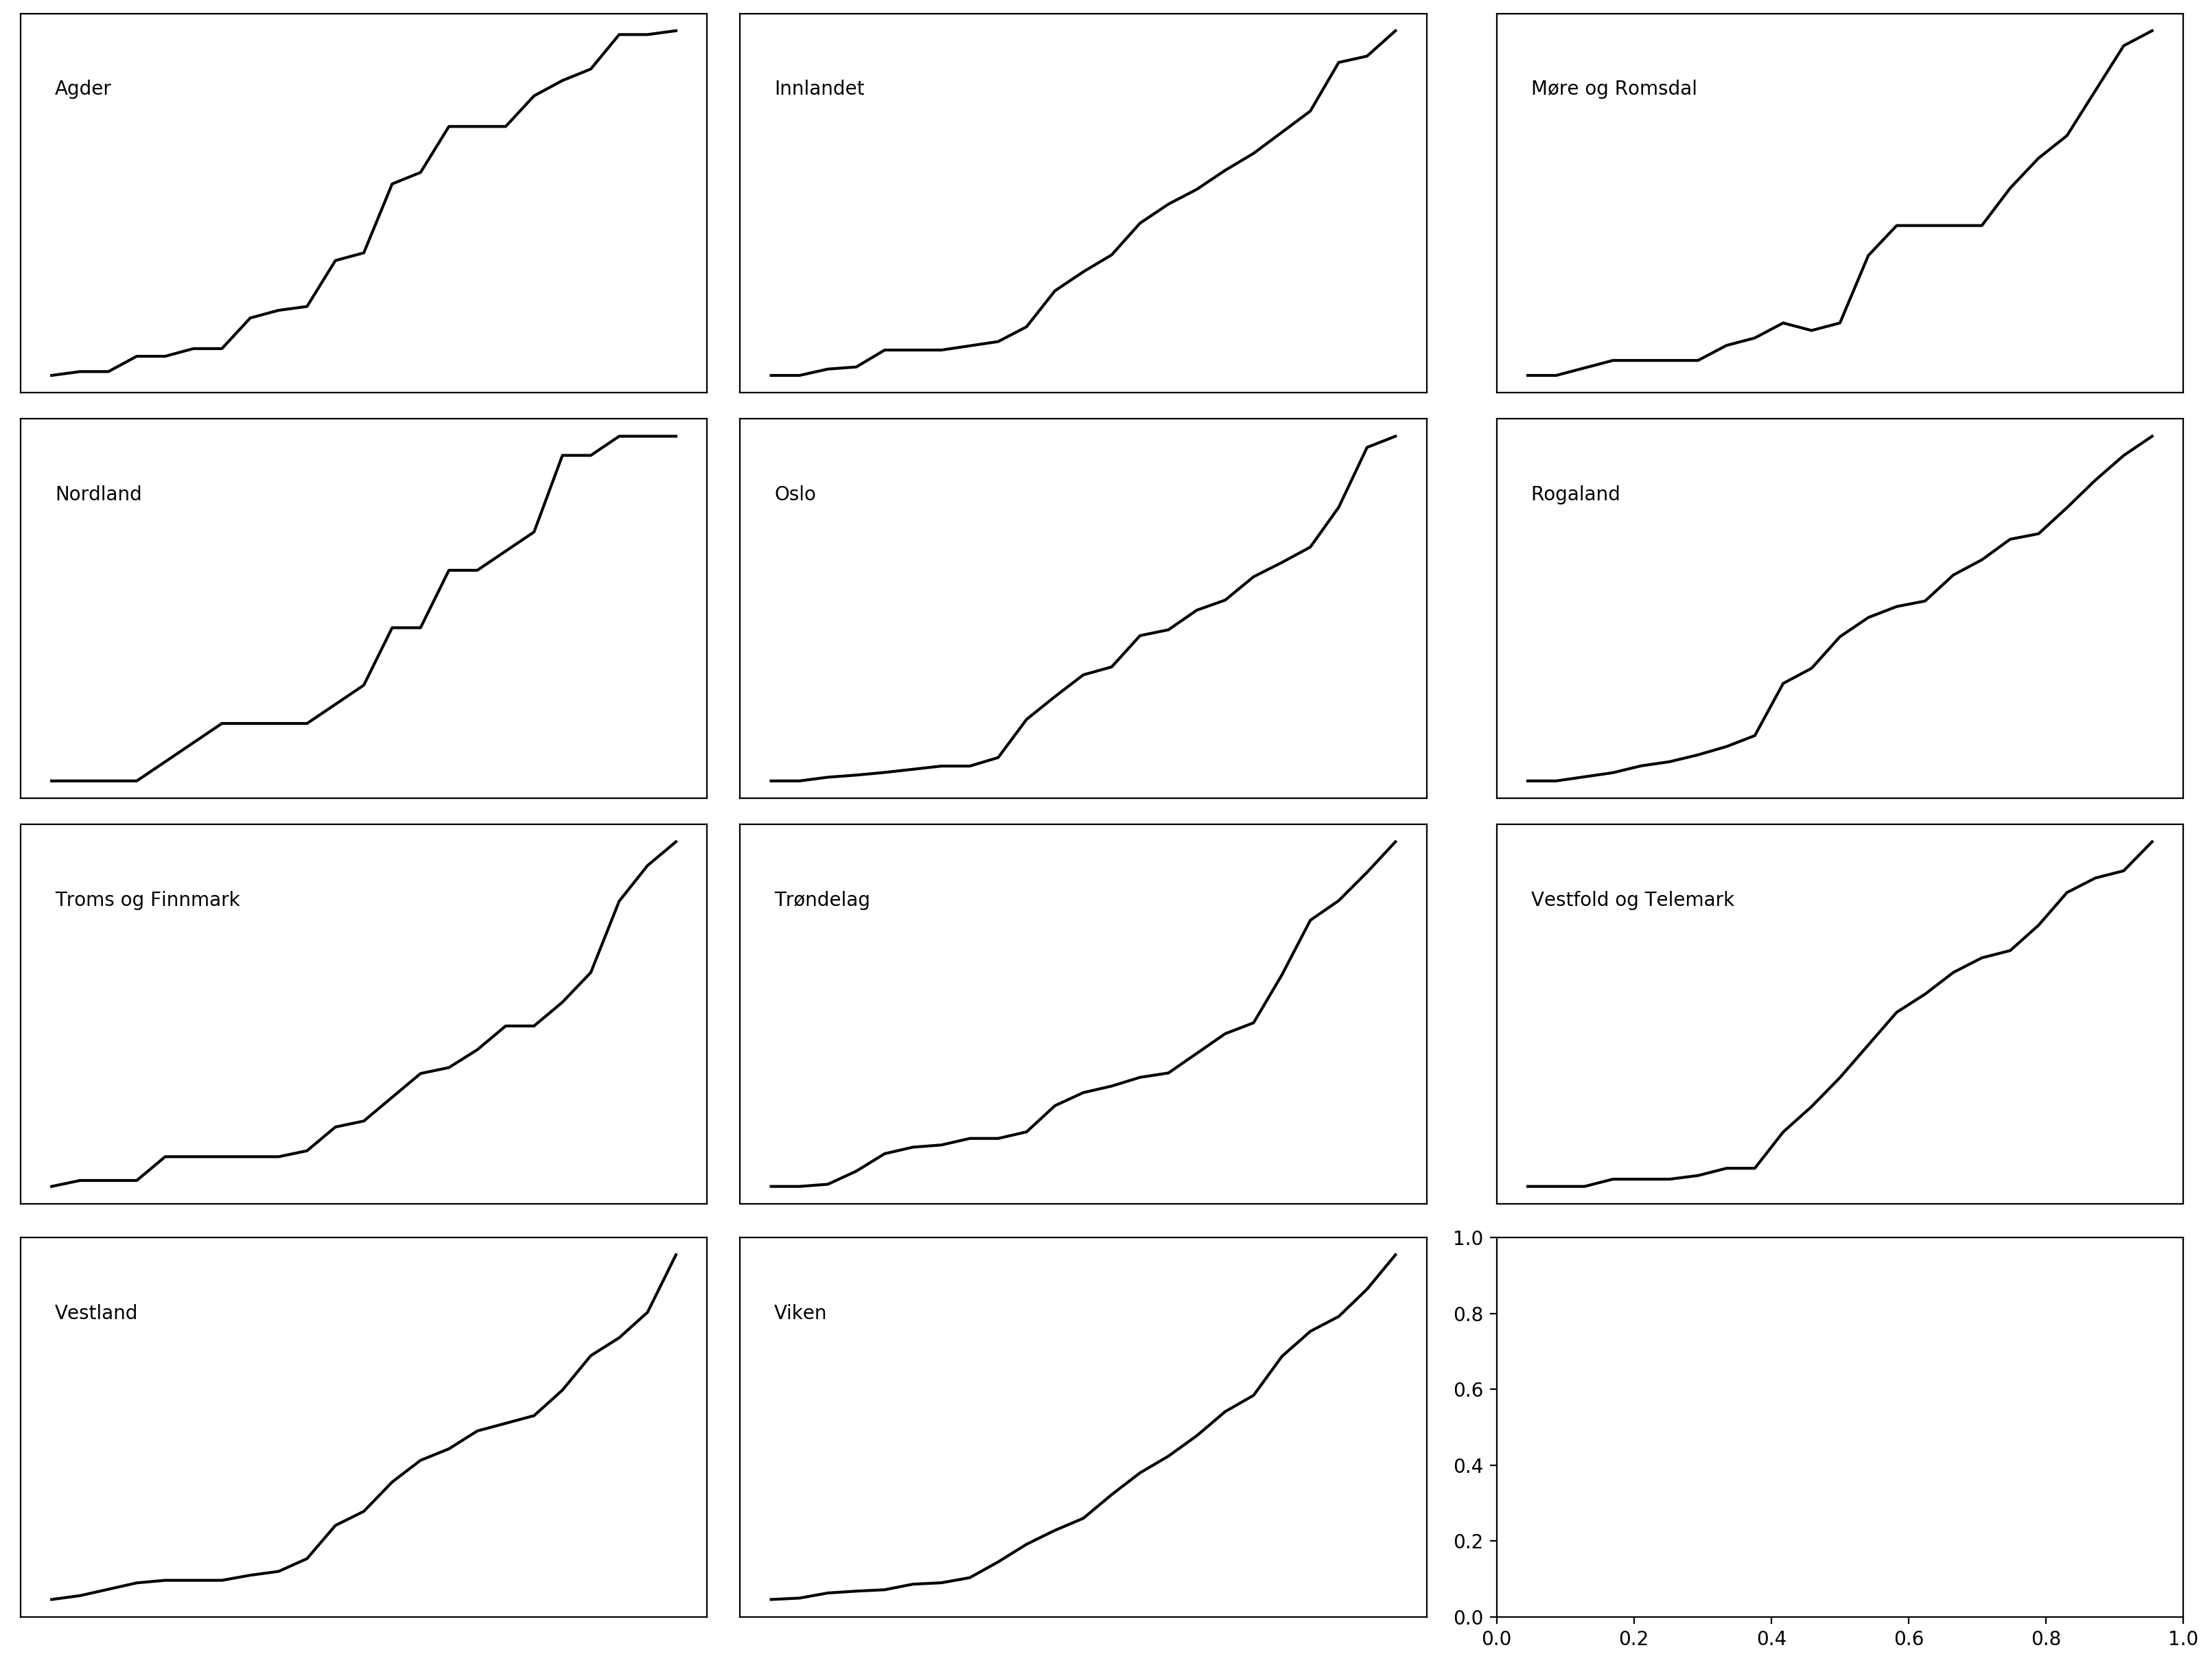

In [145]:
fig = plt.figure(figsize=(16,12), dpi=200, constrained_layout=True)

axs = fig.subplots(nrows=4, ncols=3)

for i in range(len(df.columns)):
    axs.flat[i].plot(df.index, df.iloc[:,i], color='black')
    axs.flat[i].get_xaxis().set_ticks([])
    axs.flat[i].get_yaxis().set_ticks([])
    axs.flat[i].annotate(df.iloc[:,i].name, (0.05, 0.8),xycoords='axes fraction', va='center', ha='left')
    
fig.savefig('fylker_matrix.png')

In [146]:
unstacked = df.unstack().reset_index()

unstacked = unstacked[pd.to_datetime(unstacked["variable"]) >= pd.to_datetime("2020-02-25")]

unstacked.head()

,Fylke,variable,0
0,Agder,2020-03-02,2
1,Agder,2020-03-03,3
2,Agder,2020-03-04,3
3,Agder,2020-03-05,7
4,Agder,2020-03-06,7


# moment

In [147]:
roc = df.copy()
roc = roc.pct_change(periods=2)*100/3

roc.iloc[[-1]].melt()
roc1 = roc.iloc[[-1]].melt().rename(columns={"value": "Vekstrate"}).sort_values(by=['Vekstrate'], ascending=True)
lastweek = roc.iloc[[-7]].melt().rename(columns={"value": "- 1 uke"})

vekst = roc1.merge(lastweek, how="left", on="Fylke")
vekst.head()

,Fylke,Vekstrate,- 1 uke
0,Nordland,0.000000,3.030303
1,Agder,0.366300,0.000000
2,Innlandet,3.378378,6.584362
3,Vestfold og Telemark,3.921569,6.289308
4,Rogaland,4.870624,7.633588


In [148]:
vekst["dtime"] = np.log(2)/np.log(1+(vekst["Vekstrate"]/100))
#vekst["dtime"] = (72/(vekst["Vekstrate"]))
vekst["momentum"] = vekst["Vekstrate"]-vekst["- 1 uke"]
vekst["momentum"] = vekst["momentum"].apply(lambda x: "Avtagende" if x < 0 else "Tiltagende")
vekst["text"] = "Hver "+vekst["dtime"].round(0).astype(str)+" dag"
vekst["Vekstrate"] = vekst["Vekstrate"].round(2)
vekst["- 1 uke"] = vekst["- 1 uke"].round(2)
vekst = vekst.merge(fylker, how="left", on="Fylke")

vekst

,Fylke,Vekstrate,- 1 uke,dtime,momentum,text,RHF,Befolkning
0,Nordland,0.00,3.03,inf,Avtagende,Hver inf dag,Helse Nord,241235
1,Agder,0.37,0.00,189.575543,Tiltagende,Hver 190.0 dag,Helse Sør-Øst,307231
2,Innlandet,3.38,6.58,20.861811,Avtagende,Hver 21.0 dag,Helse Sør-Øst,371385
3,Vestfold og Telemark,3.92,6.29,18.019605,Avtagende,Hver 18.0 dag,Helse Sør-Øst,419396
4,Rogaland,4.87,7.63,14.575005,Avtagende,Hver 15.0 dag,Helse Vest,479892
5,Troms og Finnmark,6.80,11.11,10.532036,Avtagende,Hver 11.0 dag,Helse Nord,243311
6,Trøndelag,6.87,11.54,10.431878,Avtagende,Hver 10.0 dag,Helse Midt-Norge,468702
7,Møre og Romsdal,7.02,0.00,10.220004,Tiltagende,Hver 10.0 dag,Helse Midt-Norge,265238
8,Viken,7.21,10.19,9.958016,Avtagende,Hver 10.0 dag,Helse Sør-Øst,1241165
9,Oslo,8.54,6.39,8.457870,Tiltagende,Hver 8.0 dag,Helse Sør-Øst,693494


In [13]:
from datetime import datetime

legend = [i for i in vekst["RHF"].unique()]
legend.sort()

fig = px.bar(vekst, 
             x='Vekstrate', y='Fylke', 
             orientation='h',
             category_orders={"RHF": legend},
             height=500,
             title = "<b>Endringer i antall registrerte smittede pr fylke</b><br>Gjennomsnittlig veksttakt siste tre dager<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             color='RHF',
             text="text",
             hover_name="Fylke",
             hover_data=["Vekstrate"],
             template = "plotly_white", 
             labels = {"Vekstrate": "daglig vekst (%)", "- 1 uke": "Daglig vekst for en uke siden", "text": "Dager før dobling med dagens vekst"},
            )

"""
fig.add_shape(
        # doubling time 2 days
        dict(
            type="line",
            x0=41.42136,
            y0=-0.5,
            x1=41.42136,
            y1=21.5,
            line=dict(
                color="Black",
                width=1
            )))
fig.add_shape(
        # doubling time 1 uke
        dict(
            type="line",
            x0=10.40895,
            y0=-0.5,
            x1=10.40895,
            y1=21.5,
            line=dict(
                color="Black",
                width=1
            )))

"""
fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text=""),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

#plotly.offline.plot(fig, filename='COVID_moment_fylke.html')
#py.plot(fig, filename='COVID19_vekstmomentum_fylker.html')

'https://plotly.com/~oystein.nerva/58/'

# animation

In [149]:
melted = pd.melt(df.reset_index(), id_vars=["variable"], var_name="Fylke", value_name="Registrerte smittede").dropna().sort_values(by=["variable"])
melted["variable"] = melted["variable"].apply(lambda x: x.strftime("%d %b"))
melted = melted.merge(fylker, how="left", on="Fylke")
melted["Smittede/tusen innb"] = melted["Registrerte smittede"]/(melted["Befolkning"]/1000)
melted["txt"] = melted["Smittede/tusen innb"].round(2).astype(str)
melted.head()

,variable,Fylke,Registrerte smittede,RHF,Befolkning,Smittede/tusen innb,txt
0,02 Mar,Agder,2,Helse Sør-Øst,307231,0.00651,0.01
1,02 Mar,Innlandet,0,Helse Sør-Øst,371385,0.00000,0.0
2,02 Mar,Troms og Finnmark,1,Helse Nord,243311,0.00411,0.0
3,02 Mar,Rogaland,0,Helse Vest,479892,0.00000,0.0
4,02 Mar,Nordland,0,Helse Nord,241235,0.00000,0.0


In [150]:
legend = [i for i in vekst["RHF"].unique()]
legend.sort()

fig = px.bar(melted, 
             x='Registrerte smittede', y='Fylke', animation_frame="variable",
             animation_group="Fylke",
             orientation='h',
             category_orders={"RHF": legend},
             labels = {"Veksttakt": "daglig vekst (%)", "variable": "Dato"},
             color='RHF',
             text="Registrerte smittede",
             height=600,
             title = "<b>COVID19: Registrert smittet i Norge</b><br>Fordeling per fylke<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             template = "plotly_white",
             range_x=[0,600]
                 ).update_yaxes(categoryorder="total ascending")

fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text=""),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

#plotly.offline.plot(fig, filename='COVID19_fylkesutvikling_animation.html')
py.plot(fig, filename='COVID19_fylkesutvikling_animation.html')
fig.show()

In [151]:
legend = [i for i in vekst["RHF"].unique()]
legend.sort()

fig = px.bar(melted, 
             x='Smittede/tusen innb', y='Fylke', animation_frame="variable",
             animation_group="Fylke",
             orientation='h',
             category_orders={"RHF": legend},
             labels = {"Veksttakt": "daglig vekst (%)", "variable": "Dato"},
             color='RHF',
             text="txt",
             height=600,
             title = "<b>COVID19: Registrert smittet i Norge</b><br>Antall smittet per 1 000 innbyggere<br>Datakilde: FHI - folkehelseinstituttet. Oppdatert " +datetime.today().strftime('%d.%m.%Y'),
             template = "plotly_white",
             range_x=[0,1]
                 ).update_yaxes(categoryorder="total ascending")

fig.layout.coloraxis.showscale = False

fig.update_layout(
    yaxis=dict(
        separatethousands=True,
        categoryorder = 'total ascending',
        title_text="",
        fixedrange=True,
    ), xaxis=dict(fixedrange=True,
                 title_text="per 1 000"),
    title_font=dict(family="Helvetica", size=18),
        margin=dict(b=150)) #bottom margin

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)'
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )

py.plot(fig, filename='COVID19_per_capita_fylkesutvikling_animation.html')
fig.show()

# sammenligning fra registrering nr 10

In [152]:
restart.head()

Fylke,Agder,Innlandet,Møre og Romsdal,Nordland,Oslo,Rogaland,Troms og Finnmark,Trøndelag,Vestfold og Telemark,Vestland,Viken
variable,,,,,,,,,,,
2020-03-02,2,0,0,0,7,0,1,0,0,9,5
2020-03-03,3,0,0,0,7,0,2,0,0,12,8
2020-03-04,3,3,1,0,14,3,2,1,0,17,19
2020-03-05,7,4,2,0,18,6,2,7,2,22,23
2020-03-06,7,12,2,1,23,11,6,15,2,24,26


In [153]:
restart = pd.melt(restart.reset_index(), id_vars=["variable"])
restart[restart["value"] < 5] = np.nan
restart = restart.apply(lambda x: pd.Series(x.dropna().values))
restart.head()

,variable,Fylke,value
0,2020-03-05,Agder,7.0
1,2020-03-06,Agder,7.0
2,2020-03-07,Agder,9.0
3,2020-03-08,Agder,9.0
4,2020-03-09,Agder,17.0


In [154]:
restart = restart.groupby(["Fylke"], as_index=False)
restart = restart.apply(lambda x: x.reset_index(drop=True)).reset_index()
restart["variable"] = restart["variable"].apply(lambda x: x.strftime("%d %b"))
restart = restart.merge(fylker, how="left", on="Fylke")
restart.head()

,level_0,level_1,variable,Fylke,value,RHF,Befolkning
0,0,0,05 Mar,Agder,7.0,Helse Sør-Øst,307231
1,0,1,06 Mar,Agder,7.0,Helse Sør-Øst,307231
2,0,2,07 Mar,Agder,9.0,Helse Sør-Øst,307231
3,0,3,08 Mar,Agder,9.0,Helse Sør-Øst,307231
4,0,4,09 Mar,Agder,17.0,Helse Sør-Øst,307231


In [197]:
kategori = [i for i in restart["Fylke"].unique()]
kategori.sort()

fig = px.scatter(restart, 
                 x="level_1", 
                 y="value", 
                 color="Fylke",
                 hover_name="Fylke",
                 hover_data=["RHF", "variable", "value"],
                 #animation_frame="variable",
                 #animation_group="RHF",
                 log_y=True,
                 height=600,
                 #category_orders={"Fylke": kategori}, 
                 #color_discrete_sequence=colorlist,
                 template = "plotly_white",
                 range_y=[3,9900],
                 title = "<b>Antall smittet med COVID-19 per fylke</b><br>Starter fra dagen hvert fylke passerte 10 smittede<br>Det gjør det mulig å sammenligne smitteraten mellom forskjellige fylker.<br>Datakilde: FHI. Oppdatert "+datetime.today().strftime('%d.%m.%Y'),
                 labels = {"level_1": "Dager siden antall smittede passerte 5", "variable": "Dato", "value": "Totalt registrerte smittede (log)"}    
                )

fig.update_traces(mode="markers+lines")

fig.update_layout(autosize=True,
    margin=dict(l=100, r=100, t=150, b=0),
    paper_bgcolor='rgba(0, 0, 0, 0)',
    #plot_bgcolor='rgb(248, 248, 255)'    
                 )
fig.update_yaxes(nticks=4)

fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=5,
            x1=50,
            y1=5121,
            line=dict(
                color="rgba(192,192,192,0.7)",
                width=1
            ))
        )

fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=5,
            x1=50,
            y1=159.981,
            line=dict(
                color="rgba(192,192,192,0.7)",
                width=1
            ))
        )
fig.add_shape(
        dict(
            type="line",
            x0=0,
            y0=5,
            x1=50,
            y1=5226006.11,
            line=dict(
                color="rgba(192,192,192,0.7)",
                width=1
            ))
        )

fig.add_annotation(
    x=40,
    y=40000,
    text="FHI anslår 86 000 smittede <br> Slutten av april.",
    showarrow=False,
    font=dict(family="Helvetica", size=12),
    align="center",
    opacity=0.8)

py.plot(fig, filename='COVID19_antall_per_fylke.html', auto_open=False)
fig.show()

In [173]:
duration = 55
target=80000
start=5

duration*np.log(2)/(np.log(target)-np.log(start))

3.9381963002538787

In [175]:
np.log(2)/np.log(3.93)

0.5064498124578554

In [182]:
np.log(2)/np.log(1+0.05)

14.206699082890461